In [936]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import pandas_ta as pta
import talib 
from ta.volatility import BollingerBands
import pytz
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.requests import StockLatestBarRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.timeframe import TimeFrameUnit
from datetime import time
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
%matplotlib inline

In [937]:
load_dotenv("../environment.env")

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret = os.getenv("ALPACA_SECRET")
alpaca_base_url = os.getenv("ALPACA_BASE_URL")

In [ ]:
# Function to start up the main client for retrieving data
def setup_historical_client(key_: str,secret_: str, base_url_: str, raw_data_: bool):
    return StockHistoricalDataClient(
        api_key=key_, 
        secret_key=secret_, 
        raw_data=raw_data_
    )

# Function to retrieve the latest bars 
def retrieve_stock_bars(client_: StockHistoricalDataClient, symbol_: str, time_interval_: int, time_unit_: TimeFrameUnit, limit_: int):
    # Get ET and UTC time zones
    eastern = pytz.timezone("America/New_York")
    utc = pytz.UTC
    # Get current time and calculate start and end time for StockBarsRequest by calculating ET then converting to UTC
    now_et = datetime.now(eastern) 
    start_et = (now_et - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    end_et = (now_et + timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    start_utc = start_et.astimezone(utc)
    end_utc = end_et.astimezone(utc)
    prev_stock_bar_params = StockBarsRequest(
        symbol_or_symbols=symbol_,
        start=start_utc,
        end=end_utc,
        timeframe=TimeFrame(
            amount=time_interval_,
            unit=time_unit_),
        limit=limit_,
        feed="iex",
        sort="desc"
    )
    return client_.get_stock_bars(request_params=prev_stock_bar_params)

# Function to retrieve the single latest bar 
def retrieve_latest(client_: StockHistoricalDataClient, symbol_: str):
    latest_params = StockLatestBarRequest(symbol_or_symbols=symbol_)
    return client_.get_stock_latest_bar(request_params=latest_params)

# Function to convert raw bar data to an easy to parse dataframe
def data_frame_from_stock_bars(data_: dict):
    ticker, bars = next(iter(data_.items()))

    if not bars:
        raise ValueError(f"No data retrieved for ticker: {ticker}")
    
    df = pd.DataFrame(bars) # Create data frame from raw data
    df.rename(columns={'o':'open', 'h':'high','l':'low','c':'close','v':'volume','t':'timestamp'}, inplace=True) # Rename columns
    df['timestamp'] = pd.to_datetime(df['timestamp']) # Set time stamp to type datetime
    df.set_index('timestamp', inplace=True) # Index using time stamp
    eastern_time_zone = pytz.timezone("America/New_York") # Create ET timezone 
    df.index = df.index.tz_convert(eastern_time_zone) # Convert data frame times from UTC to ET 

    df['market_status'] = df.index.map(classify_market_status) # Use helper function to get market status

    return df[['close','high','low','open','volume', 'market_status']]

# Helper function used to classify market status in dataframe
def classify_market_status(dt: pd.Timestamp) -> str:
    t = dt.time()
    if time(4, 0) <= t < time(9, 30):
        return "pre-market"
    elif time(9, 30) <= t < time(16, 0):
        return "regular"
    elif time(16, 0) <= t < time(20, 0):
        return "after-hours"
    else:
        return "closed"

def filter_regular_hours(data_: pd.DataFrame) -> pd.DataFrame: 
    return data_[data_["market_status"] == "regular"]

def add_technical_indicators(data_: pd.DataFrame) -> pd.DataFrame:
    data_ = data_.sort_index().copy()
    data_['ATR'] = data_.ta.atr(length=14)
    
    # RSI with 7-period for minute data
    data_['RSI_7'] = data_.ta.rsi(length=7)
    
    # Williams %R with 14-period for minute data
    data_['Williams_R_14'] = data_.ta.willr(length=14)
    
    # ADX with 7-period for trend strength
    data_.ta.adx(length=7, append=True)

    # ADX with 14-period for trend strength
    data_.ta.adx(length=14, append=True)
    
    # Volume Rate of Change with 10-period for minute data (manual implementation)
    data_['VROC_10'] = ((data_['volume'] - data_['volume'].shift(10)) / data_['volume'].shift(10)) * 100
    
    # MACD with (5,13,5) for minute data
    data_.ta.macd(fast=5, slow=13, signal=5, append=True)
    
    data_['MA10'] = data_.ta.sma(length=10)
    # data_['MA15'] = data_.ta.sma(length=15)
    data_['MA20'] = data_.ta.sma(length=20)
    # data_['MA25'] = data_.ta.sma(length=25)
    data_['MA30'] = data_.ta.sma(length=30)
    # data_['MA35'] = data_.ta.sma(length=35)
    # data_['MA40'] = data_.ta.sma(length=40)

    # Bollinger Bands + indicator (pandas-ta)
    data_.ta.bbands(length=20, std=2, mamode='sma', append=True)
    data_['BBand'] = (data_['close'] > data_['BBU_20_2.0']).astype(int)
    return data_

# Creates target variable for ML prediction
# New column "Higher/Lower" indicates whether the NEXT candlestick's open price
# will be higher (1), lower (-1), or same (0) than the CURRENT close price
# Note: Data is sorted chronologically (oldest first) to ensure proper time sequence
def classify_price_gap(data_: pd.DataFrame) -> pd.DataFrame:
    data_ = data_.copy()
    # Sort by timestamp to ensure chronological order (oldest first)
    data_ = data_.sort_index()
    
    # Calculate whether the NEXT candlestick's open is higher/lower than CURRENT close
    # This creates a target variable for ML prediction
    data_['next_open_vs_current_close'] = data_['open'].shift(-1) - data_['close']
    data_['Higher/Lower'] = data_['next_open_vs_current_close'].apply(
        lambda x: -1 if x < 0 else (1 if x > 0 else 0)
    )
    # Drop the last row since we can't predict the next candlestick for it
    # data_ = data_.dropna()
    return data_

In [939]:
class Net(nn.Module):
    def __init__(self, in_features, hl1, hl2, hl3, out_features=2):  # Changed to 2 for binary classification
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=hl1)
        self.fc2 = nn.Linear(in_features=hl1, out_features=hl2)
        self.fc3 = nn.Linear(in_features=hl2, out_features=hl3)
        self.out = nn.Linear(in_features=hl3, out_features=out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)

        return x

In [940]:
# Create Neural Network Object
params = 14  # Updated for new features: ATR, RSI_7, Williams_R_14, ADX_7, ADX_14, VROC_10, MACD_5_13_5, MACDh_5_13_5, MACDs_5_13_5, MA10, MA20, MA30, volume, BBand
Net = Net(in_features=params, hl1=params**3, hl2=params**3, hl3=params**2)

In [941]:
# Load data for training
# Use dataframe

client = setup_historical_client(ALPACA_API_KEY, ALPACA_SECRET, ALPACA_BASE_URL, raw_data_=True)
raw_data = retrieve_stock_bars(client, "AAPL", 1, TimeFrameUnit.Minute, 10000)
raw_data_frame = data_frame_from_stock_bars(raw_data)
filtered_hours_data = filter_regular_hours(raw_data_frame)
technical_indicators_data = add_technical_indicators(filtered_hours_data)
price_gap_data = classify_price_gap(technical_indicators_data)
clean_data = price_gap_data.dropna()  # Remove NaN
clean_data = clean_data[clean_data['Higher/Lower'] != 0]

AttributeError: 'AnalysisIndicators' object has no attribute 'vroc'

In [ ]:
# Set up data for training
# X = clean_data[['close', 'high', 'low', 'open', 'volume', 'ATR', 'RSI', 'MA40', 'MA80', 'MA160', 'BBand']]
X = clean_data[['ATR', 'RSI_7', 'Williams_R_14', 'ADX_7', 'ADX_14', 'VROC_10', 'MACD_5_13_5', 'MACDh_5_13_5', 'MACDs_5_13_5', 'MA10', 'MA20', 'MA30', 'volume', 'BBand']]
y = clean_data['Higher/Lower']
X = X.values
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Convert data to torch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert targets from -1/1 to 0/1 for CrossEntropyLoss
y_train = torch.LongTensor((y_train + 1) // 2)  # -1 becomes 0, 1 becomes 1
y_test = torch.LongTensor((y_test + 1) // 2)    # -1 becomes 0, 1 becomes 1

In [ ]:
# Create class weights due to imbalancing
# class_counts = torch.bincount(y_train)
# total_samples = len(y_train)
# class_weights = (total_samples / (len(class_counts) * class_counts)).float()
# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=1e-3)

In [ ]:
# Focus on training the network - epochs and losses
loses = []
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    y_pred = Net.forward(X_train)
    # Calculate loss
    loss = criterion(y_pred, y_train) # input target

    # Save loss
    loses.append(loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    # No norm clipping
    # nn.utils.clip_grad_norm_(Net.parameters(), 0.5)
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} loss: {loss.item()}")

Epoch 0 loss: 24.222909927368164
Epoch 100 loss: 2.450627326965332
Epoch 200 loss: 0.6904721856117249
Epoch 300 loss: 0.805426299571991
Epoch 400 loss: 0.7084929347038269
Epoch 500 loss: 0.6653233170509338
Epoch 600 loss: 0.8190430998802185
Epoch 700 loss: 0.6447839140892029
Epoch 800 loss: 0.6339762806892395
Epoch 900 loss: 0.624228835105896


Text(0.5, 0, 'Epoch')

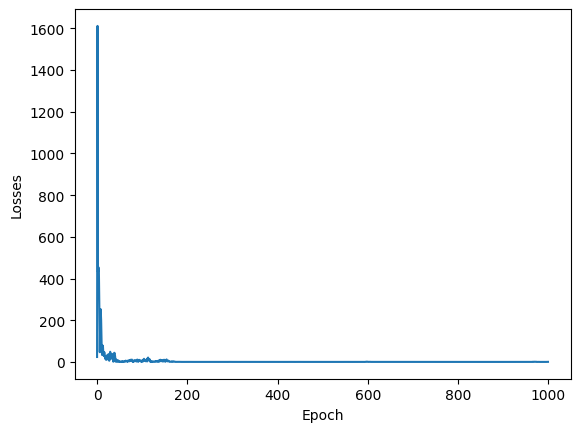

In [ ]:
# Plot loss on training data
plt.plot(range(epochs), loses)
plt.ylabel("Losses")
plt.xlabel("Epoch")

In [ ]:
# Evaluate Model on Test Data 
with torch.no_grad():
    y_eval = Net.forward(X_test) # Get y_eval on test data
    loss = criterion(y_eval, y_test) # Get loss 


In [ ]:
# Back test Data
correct = 0
count_0 = 0
count_1 = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = Net.forward(data)

        print(f'{i+1}: {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

        if y_val.argmax().item() == 0:
            count_0 += 1
        if y_val.argmax().item() == 1:
            count_1 += 1
        if y_val.argmax().item() == y_test[i]:
            correct += 1

print(f'Correct: {correct} \n Zeroes: {count_0} \n Ones: {count_1} \n Accuracy: {correct/len(X_test)}')

1: tensor([8.3790, 4.3487]) 	 0 	 0
2: tensor([21.2888, 22.6822]) 	 1 	 1
3: tensor([12.0192,  5.1386]) 	 0 	 0
4: tensor([40.6457, 44.0162]) 	 0 	 1
5: tensor([ 9.9978, 10.7390]) 	 0 	 1
6: tensor([19.1481, 20.3912]) 	 0 	 1
7: tensor([8.2740, 4.2809]) 	 1 	 0
8: tensor([8.5192, 9.1986]) 	 1 	 1
9: tensor([15.1935, 16.0730]) 	 1 	 1
10: tensor([18.5304, 19.7599]) 	 0 	 1
11: tensor([14.5874, 15.4384]) 	 1 	 1
12: tensor([12.0345, 12.6852]) 	 1 	 1
13: tensor([44.6079, 48.2184]) 	 1 	 1
14: tensor([ 9.6981, 10.3835]) 	 1 	 1
15: tensor([44.9625, 48.5474]) 	 0 	 1
16: tensor([12.2368, 13.1272]) 	 0 	 1
17: tensor([18.9567, 20.0323]) 	 0 	 1
18: tensor([7.3307, 7.1085]) 	 1 	 0
19: tensor([21.5887, 22.9502]) 	 0 	 1
20: tensor([60.2104, 65.4321]) 	 1 	 1
21: tensor([ 9.7244, 10.3935]) 	 0 	 1
22: tensor([18.9233, 20.0349]) 	 0 	 1
23: tensor([13.9841, 14.8546]) 	 0 	 1
24: tensor([17.0857, 18.4975]) 	 0 	 1
25: tensor([22.5703, 24.0670]) 	 1 	 1
26: tensor([16.5534, 17.5706]) 	 0 	 1
27: